In [1]:
import seaborn as sns
from pandas import DataFrame
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler

from main import get_dataframe, iterate_mixedml, loop_mixedml


In [2]:
X_LABELS = ["x2_x5", "x4_x7", "x6_x8"]

# the paper says "y_fixed" for "y fixed effects"
# but it can be understood as "y not changing"
# so I call it "y_fe"
Y_LABEL = "y_mixed_obs"  # the values are fixed
Y_LABEL_FE = Y_LABEL + "_fixed"  # the value are not fixed

In [3]:
data = get_dataframe("../../data/synthetic_bph_1/01_test.csv")
data = data[data["individus"] < 20]
data = data[["individus"] + X_LABELS + [Y_LABEL]]
data[X_LABELS + [Y_LABEL]] = RobustScaler().fit_transform(data[X_LABELS + [Y_LABEL]])

In [4]:
data

,individus,x2_x5,x4_x7,x6_x8,y_mixed_obs
0,1,-0.802429,-0.471798,0.0,-1.129335
1,1,-0.744390,-0.323000,0.0,-0.932142
2,1,-0.716285,-0.249475,0.0,-0.896724
3,1,-0.700024,-0.222418,0.0,-0.858849
4,1,-0.690015,-0.214187,0.0,-0.905740
...,...,...,...,...,...
489,19,0.030368,-0.211567,0.0,-0.074280
490,19,0.030368,-0.211567,0.0,-0.071697
491,19,0.030368,-0.211567,0.0,-0.044650
492,19,0.030368,-0.211567,0.0,0.031557


In [5]:
??iterate_mixedml

Signature:
iterate_mixedml(
    ml_fixed: sklearn.neural_network._multilayer_perceptron.MLPRegressor,
    df_data: pandas.core.frame.DataFrame,
) -> tuple[sklearn.neural_network._multilayer_perceptron.MLPRegressor, pandas.core.frame.DataFrame, bool]
Docstring: <no docstring>
Source:   
def iterate_mixedml(
    ml_fixed: MLPRegressor, df_data: DataFrame
) -> tuple[MLPRegressor, DataFrame, bool]:

    #### fitting the Machine Learning model
    X = df_data[X_LABELS]
    y = df_data[Y_LABEL_FE]
    # we train ml_fixed by ignoring cluster effects (with the target y)
    ml_fixed.fit(X, y)
    # to get an estimate of y_fixed
    try:
        y_fixed = ml_fixed.predict(X)
    except AttributeError:
        y_fixed = ml_fixed.run(X)

    #### fitting the Mixed Effect model
    # based on e_fixed
    # !!! l'erreur était là (j'utilisais "y- y_fixed")
    df_data["e_fixed"] = df_data[Y_LABEL] - y_fixed
    df_data.to_csv("ml_pred.csv", index=False)
    # we estimate u
    call(["Rscript", "rand

In [6]:
%cat random_effects_fitting.R

library(lcmm)

data <- read.csv2('ml_pred.csv', sep = ',', dec = '.')
data$x6_x8 <- as.numeric(data$x6_x8)


data$individus <- as.numeric(data$individus)
random_hlme <- hlme(
  e_fixed ~ 1,
  random = ~  x2_x5 + x4_x7 + x6_x8,
  # cor = AR(temps) ou BM(temps)
  idiag = TRUE,
  data = data,
  subject = 'individus',
)

write.table(
  random_hlme$pred,
  "random_preds.csv",
  sep = ",",
  dec = ".",
  row.names = FALSE
)

saveRDS(random_hlme, 'random_hlme.Rds')


In [7]:
model = MLPRegressor(hidden_layer_sizes=(40, 30, 20), max_iter=5000)

MAX_ITER = 100
results = loop_mixedml(model, data, n_iter_improve=20, max_iter=MAX_ITER)

mixedML step #00: 1.483951e-02 (best)
mixedML step #01: 9.526225e-03 (best)
mixedML step #02: 6.974576e-03 (best)
mixedML step #03: 5.617750e-03 (best)
mixedML step #04: 5.183712e-03 (best)
mixedML step #05: 5.045568e-03 (best)
mixedML step #06: 4.732988e-03 (best)
mixedML step #07: 4.548513e-03 (best)
mixedML step #08: 4.596505e-03
mixedML step #09: 4.500780e-03 (best)
mixedML step #10: 4.493662e-03 (best)
mixedML step #11: 4.616459e-03
mixedML step #12: 4.563201e-03
mixedML step #13: 4.404150e-03 (best)
mixedML step #14: 4.618255e-03
mixedML step #15: 4.550459e-03
mixedML step #16: 4.445054e-03
mixedML step #17: 4.486731e-03
mixedML step #18: 4.543133e-03
mixedML step #19: 4.443493e-03
mixedML step #20: 4.518804e-03
mixedML step #21: 4.496486e-03
mixedML step #22: 4.501979e-03
mixedML step #23: 4.481591e-03
mixedML step #24: 4.426681e-03
mixedML step #25: 4.445402e-03
mixedML step #26: 4.457387e-03
mixedML step #27: 4.441254e-03
mixedML step #28: 4.432565e-03
mixedML step #29: 4.3774

In [ ]:
first, best = results[0], min(results)

(best - first / first

<Axes: >

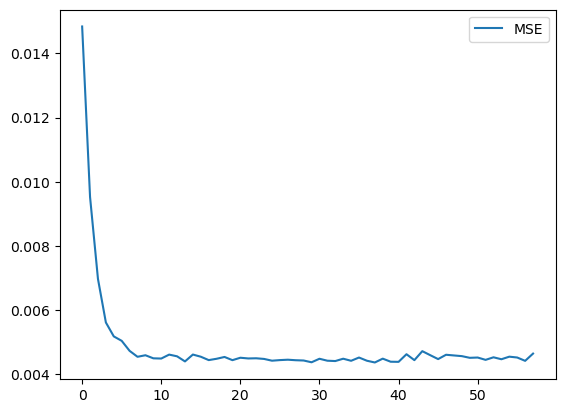

In [8]:
sns.lineplot(DataFrame(results, columns=['MSE']))